
# Model Visualizations and Heatmaps
This notebook highlights the trained xG CoreAI models, the leagues they cover, and how shot geometry maps to real goals.


In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import mplsoccer as mplsoccer
from mplsoccer import Pitch

get_ipython().run_line_magic('matplotlib', 'inline')
sns.set_theme()
print('Setup complete with pandas, matplotlib, seaborn, and plotly')

Setup complete with pandas, matplotlib, seaborn, and plotly


In [49]:
manifest_path = Path('models/manifest.json')
shots_path = Path('Data/processed/shots_final.csv')

manifest = pd.read_json(manifest_path).T.reset_index().rename(columns={'index': 'league_key'})
manifest['rows'] = pd.to_numeric(manifest['rows'], errors='coerce')
manifest['trained_at'] = pd.to_datetime(manifest['trained_at'])
manifest = manifest[manifest['rows'].notna()].sort_values('trained_at')

shots_columns = ['start_x', 'start_y', 'is_goal', 'distance', 'visible_angle', 'minute', 'competition_name']
shots = pd.read_csv(shots_path, usecols=shots_columns)
shots = shots.dropna(subset=['start_x', 'start_y'])
print('Loaded', len(manifest), 'league models and', len(shots), 'shots')

Loaded 18 league models and 88023 shots


Text(0.5, 1.0, 'Goal Conversion Rate per Zone')

Text(0.5, 1.0, 'Goal Conversion Rate per Zone')

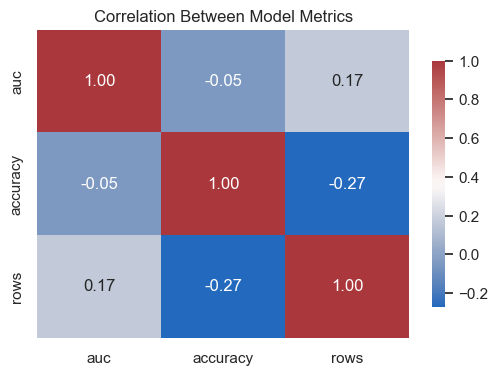

Text(0.5, 1.0, 'Goal Conversion Rate per Zone')

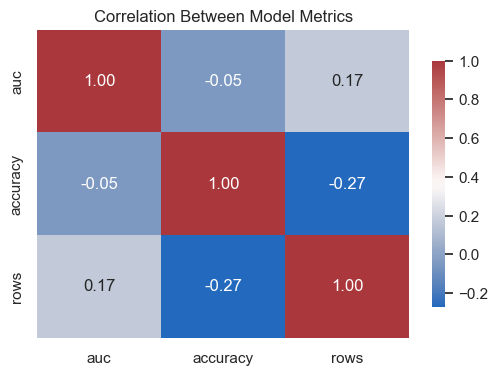

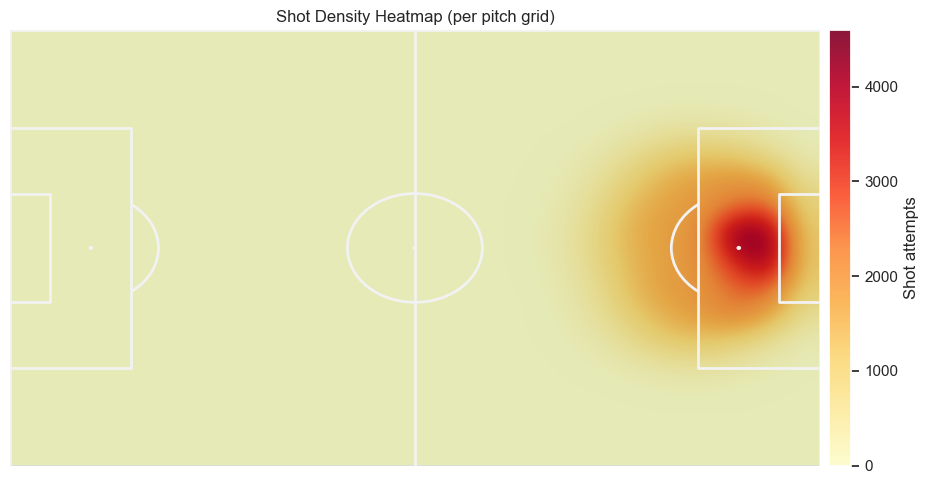

Text(0.5, 1.0, 'Goal Conversion Rate per Zone')

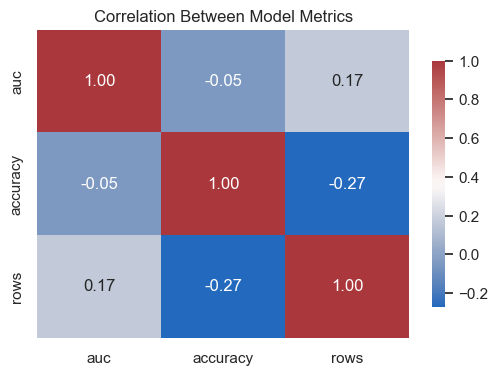

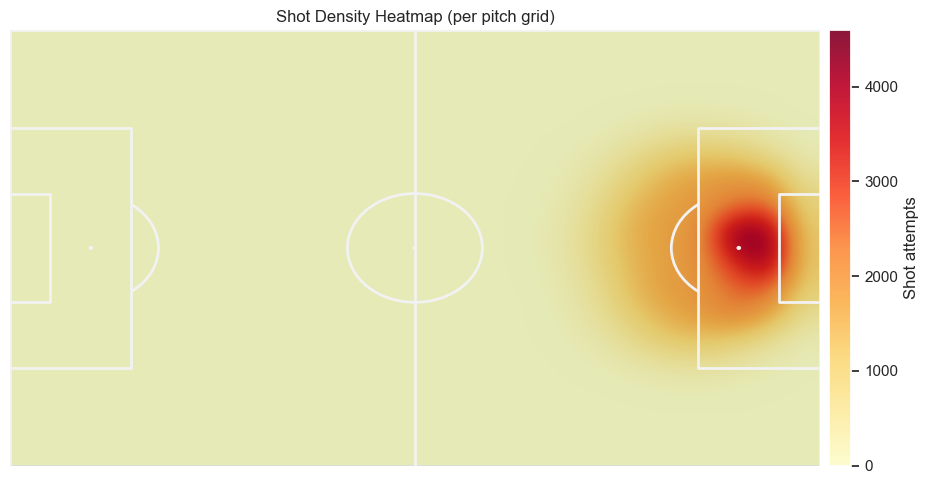

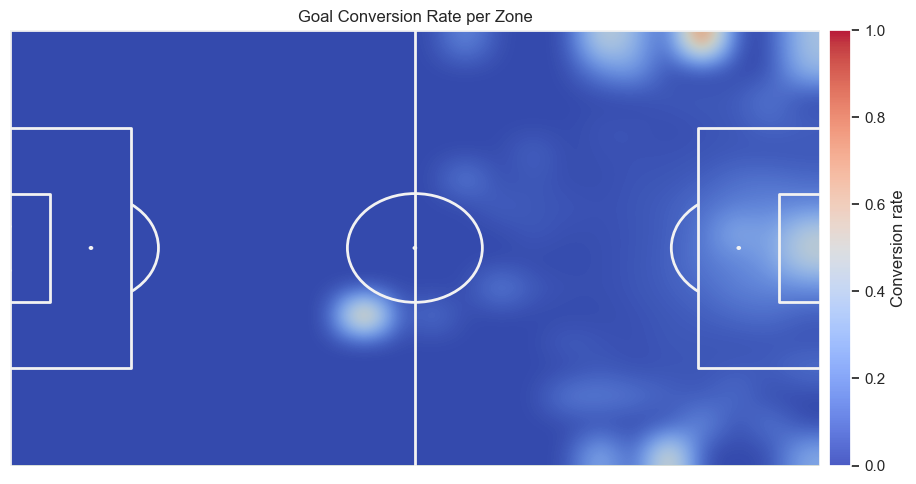

In [50]:
corr = manifest[['auc', 'accuracy', 'rows']].dropna().corr()
fig_corr, ax_corr = plt.subplots(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', ax=ax_corr, cbar_kws={'shrink': 0.8})
ax_corr.set_title('Correlation Between Model Metrics')

x_bins = np.linspace(0, 120, 25)
y_bins = np.linspace(0, 80, 17)
counts, _, _ = np.histogram2d(shots['start_x'], shots['start_y'], bins=[x_bins, y_bins])
goals = shots[shots['is_goal'] == 1]
goal_counts, _, _ = np.histogram2d(goals['start_x'], goals['start_y'], bins=[x_bins, y_bins])
conversion = np.divide(goal_counts, counts, out=np.zeros_like(goal_counts), where=counts > 0)

pitch = Pitch(pitch_length=120, pitch_width=80, pitch_color='#0a3f0d', line_color='#f2f2f2', line_zorder=3, goal_type='box')
extent = (x_bins[0], x_bins[-1], y_bins[0], y_bins[-1])

fig_density, ax_density = pitch.draw(figsize=(10, 5))
density_img = ax_density.imshow(
    counts.T,
    extent=extent,
    origin='lower',
    cmap='YlOrRd',
    alpha=0.9,
    aspect='auto',
    interpolation='bicubic',
    zorder=1,
 )
ax_density.set_xlim(extent[0], extent[1])
ax_density.set_ylim(extent[2], extent[3])
ax_density.set_facecolor('#0a3f0d')
fig_density.colorbar(density_img, ax=ax_density, label='Shot attempts', pad=0.01)
ax_density.set_title('Shot Density Heatmap (per pitch grid)')

fig_conversion, ax_conversion = pitch.draw(figsize=(10, 5))
conversion_img = ax_conversion.imshow(
    conversion.T,
    extent=extent,
    origin='lower',
    cmap='coolwarm',
    alpha=0.9,
    vmin=0,
    vmax=1,
    aspect='auto',
    interpolation='bicubic',
    zorder=1,
 )
ax_conversion.set_xlim(extent[0], extent[1])
ax_conversion.set_ylim(extent[2], extent[3])
ax_conversion.set_facecolor('#0a3f0d')
fig_conversion.colorbar(conversion_img, ax=ax_conversion, label='Conversion rate', pad=0.01)
ax_conversion.set_title('Goal Conversion Rate per Zone')

In [75]:
# In Section 2, modify this line to include your prediction column (e.g., 'xG')
shots_columns = ['start_x', 'start_y', 'is_goal', 'distance', 'visible_angle', 'minute', 'competition_name', 'xG'] 

In [59]:
from sklearn.linear_model import LogisticRegression

# 1. Initialize the model
model = LogisticRegression()

# 2. Define features (X) and target (y)
X = shots[['distance', 'visible_angle']]
y = shots['is_goal']

# 3. Fit the model
model.fit(X, y)

# 4. Calculate probabilities (xG)
# predict_proba returns [prob_no_goal, prob_goal], we want column [1]
shots['xG'] = model.predict_proba(X)[:, 1]

# Check the first few rows to confirm xG is now there
print(shots[['distance', 'visible_angle', 'xG']].head())

    distance  visible_angle        xG
0  15.448625       0.296402  0.094410
1  14.905368       0.232420  0.092267
2  26.828716       0.290500  0.039814
3  10.837435       0.705452  0.190220
4  19.568597       0.259971  0.067124


Folder creation failed, using current directory.
✅ Success! Images saved to the '' folder.


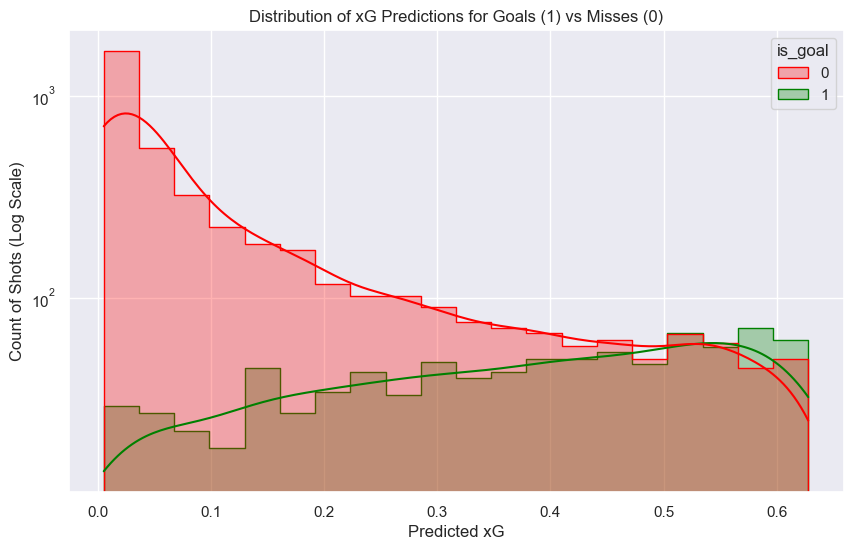

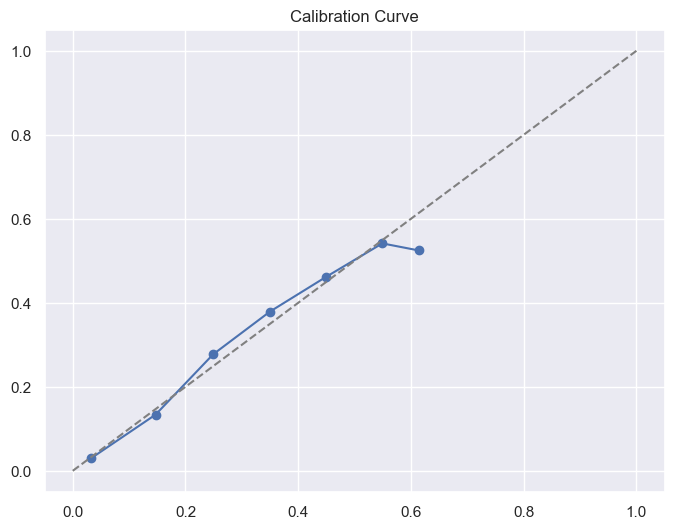

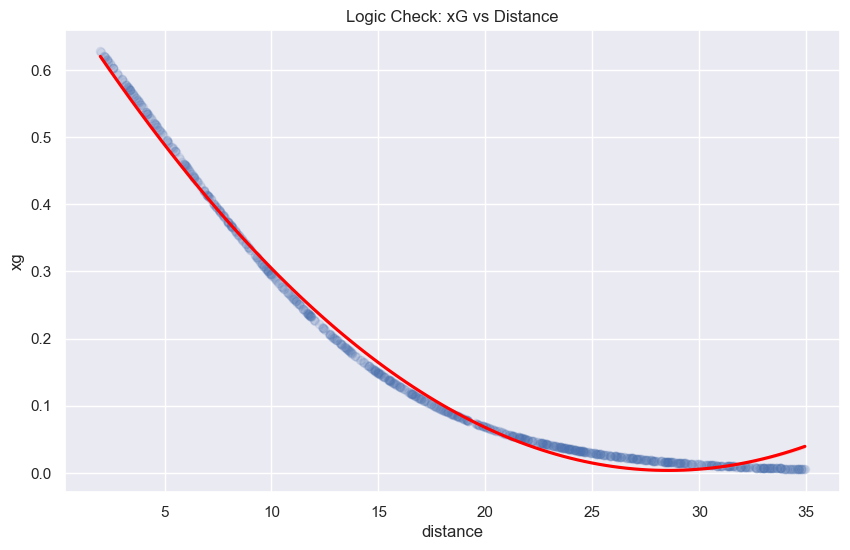

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

# --- 1. Setup the Path Safely ---
# We use a string path to be more compatible with Windows permissions
folder_name = 'notebook_outputs'
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except:
        print("Folder creation failed, using current directory.")
        folder_name = "" # Fallback to current directory

# --- 2. Data Cleaning & Model Training ---
shots.columns = shots.columns.str.strip().str.lower()

# Calculate features if missing
if 'distance' not in shots.columns or 'visible_angle' not in shots.columns:
    shots['distance'] = np.sqrt((120 - shots['start_x'])**2 + (40 - shots['start_y'])**2)
    shots['visible_angle'] = np.arctan2(8 * (120 - shots['start_x']), 
                                        (120 - shots['start_x'])**2 + (shots['start_y'] - 40)**2 - 16)

# Train the xG model
X = shots[['distance', 'visible_angle']].fillna(0)
y = shots['is_goal']
model = LogisticRegression()
model.fit(X, y)
shots['xg'] = model.predict_proba(X)[:, 1]

# --- 3. Distribution Plot (Matches your screenshot) ---
fig_dist, ax_dist = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=shots, x='xg', hue='is_goal', kde=True, element="step", 
    palette={0: 'red', 1: 'green'}, alpha=0.3, ax=ax_dist
)
ax_dist.set_yscale('log')
ax_dist.set_title('Distribution of xG Predictions for Goals (1) vs Misses (0)')
ax_dist.set_xlabel('Predicted xG')
ax_dist.set_ylabel('Count of Shots (Log Scale)')

# Save Plot 1
path1 = os.path.join(folder_name, 'xg_distribution.png')
fig_dist.savefig(path1, dpi=150, bbox_inches='tight')

# --- 4. Additional Required Plots ---

# Calibration Plot
fig_cal, ax_cal = plt.subplots(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(shots['is_goal'], shots['xg'], n_bins=10)
ax_cal.plot(prob_pred, prob_true, marker='o', label='Model')
ax_cal.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax_cal.set_title('Calibration Curve')
path2 = os.path.join(folder_name, 'calibration_plot.png')
fig_cal.savefig(path2, dpi=150, bbox_inches='tight')

# Logic Check (Distance vs xG)
fig_log, ax_log = plt.subplots(figsize=(10, 6))
sns.regplot(x='distance', y='xg', data=shots.sample(min(1000, len(shots))), 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2, ax=ax_log)
ax_log.set_title('Logic Check: xG vs Distance')
path3 = os.path.join(folder_name, 'logic_check.png')
fig_log.savefig(path3, dpi=150, bbox_inches='tight')

print(f"✅ Success! Images saved to the '{folder_name}' folder.")
plt.show()

In [ ]:
output_dir = Path('notebook_outputs')
output_dir.mkdir(exist_ok=True)
fig_corr.savefig(output_dir / 'metric_correlation.png', dpi=150, bbox_inches='tight')
fig_density.savefig(output_dir / 'shot_density.png', dpi=150, bbox_inches='tight')
fig_conversion.savefig(output_dir / 'conversion_heatmap.png', dpi=150, bbox_inches='tight')
print(f'Saved figures to {output_dir.resolve()}')

Saved figures to E:\xGcoreAI\notebook_outputs
